## LICENSE

In [ ]:
#   =================== aMD/MD/MSM Analysis STEP IV v1.0 ====================   #
#    Copyright (C) 2016-2018   Jordi Juarez-Jimenez, PhD                        #
#    Michel Lab, The University of Edinburgh                                    #
#                                                                               #
#    This program is free software: you can redistribute it and/or modify       #
#    it under the terms of the GNU General Public License as published by       #
#    the Free Software Foundation, either version 3 of the License, or          #
#    (at your option) any later version.                                        #
#                                                                               #
#    This program is distributed in the hope that it will be useful,            #
#    but WITHOUT ANY WARRANTY; without even the implied warranty of             #
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the              #
#    GNU General Public License for more details.                               #
#                                                                               #
#    You should have received a copy of the GNU General Public License          #
#    along with this program.  If not, see <https://www.gnu.org/licenses/>.     #
#################################################################################

# This script was used to obtain some of the results reported in:
# Jordi Juárez-Jiménez*, Arun A. Gupta, Gogulan Karunanithy, Antonia S. J. S. Mey, 
# Charis Georgiou, Harris Ioannidis, Alessio De Simone, Paul N. Barlow, Alison N. Hulme,
# Malcolm D. Walkinshaw, Andrew J. Baldwin and  Julien Michel*
# "Dynamic design: manipulation of millisecond timescale motions on the energy landscape 
# of cyclophilin A" , Chem. Sci., 2020, 11, 2670
# Please cite that work if you find this script useful.

## IMPORTS

In [1]:
%pylab inline
import pyemma.msm as msm
import pyemma.plots as mplt
import pickle,os, sys
import pyemma
import pyemma.coordinates as coor
import msmtools

Populating the interactive namespace from numpy and matplotlib
You are still using msmtools from the deprecated Omnia channel. Please switch to conda-forge to catch future updates.
In order to do so please set conda-forge channel to highest priority by:

    conda config --add channels conda-forge

and update this package by:

    conda update msmtools




/home/soft/miniconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
print "Pyemma v: %s" % pyemma.version
print "msmtools v: %s" % msmtools._version.get_versions()

Pyemma v: 2.4
msmtools v: {u'full-revisionid': u'958fde79da899e0d3616306a00864011a3de761c', u'dirty': False, u'version': u'1.2.1', u'error': None}


## AUX FUNCTIONS

In [4]:
def avg_by_set(x,sets):
    avg = np.zeros(len(sets))
    for i in range(len(sets)):
        I = list(sets[i])
        avg[i] = np.mean(x[I])
    return avg

def get_corrected_dist(M):
    '''(msm_object)->np.array
    
    '''
    j = 0
    corrected = []
    if len(M.stationary_distribution) == 100:
        corrected = M.stationary_distribution
    else:
        for i in range(100):
            if i not in M.active_set:
                corrected.append(0.00000)
                j = j + 1
            else:
                corrected.append(M.stationary_distribution[i - j])
                
    return corrected

def pop_over_states(pop_dict,states,macrostate,stationary_distribution):
    '''(dict, array_like, str, array_like)-> int
    
        For each state in states will look up its probability in the stationary distribution
        and append the summ to the corresponding entry in pop_dict[macrostate]
        
    '''
    pop = 0 
    for state in states:
        pop = pop + stationary_distribution[state]
    pop_dict[macrostate].append(pop)
    return 1

def sample_from_crisp_assigment(dtrajs,assignment,nsample):
    '''(pyemma.dtrajs, array like,int) -> array_like
    
    '''
    samples =[]
    for state in assignment:
        samples.append([])
    while True:
        progress = 0
        for i in range(len(samples)):
            progress = progress + len(samples[i])
        if len(assignment)*nsample == progress:
            break
        else:
            traj = int(np.random.randint(0,high=len(dtrajs),size=1))
            snapshot = int(np.random.randint(0,high=len(dtrajs[traj]), size=1))
            state=int(dtrajs[traj][snapshot])
            for j in range(len(assignment)):
                if state in assignment[j] and len(samples[j]) < nsample:
                    samples[j].append([traj,snapshot])
                    continue
    def_samples = []
    for temp in samples:
        def_samples.append(np.array(temp))
    return def_samples

def get_microstate_samples(dtrajs,stat_distribution,nsample):
    '''(msm.dtrajs, array like,int) -> array_like
    
    Search in dtrajs for nsamples for each microstate in stat_distribution
    
    
    '''
    samples =[]
    completed_microstates = []
    for state in stat_distribution:
        samples.append([])
        
    while len(completed_microstates) < len(stat_distribution):
        #progress = 0
        
        traj = int(np.random.randint(0,high=len(dtrajs),size=1))
        snapshot = int(np.random.randint(0,high=len(dtrajs[traj]), size=1))
        state=int(dtrajs[traj][snapshot])
        
        if state not in completed_microstates:
            if [traj, snapshot] not in samples[state]:
                samples[state].append([traj,snapshot])
                if len(samples[state]) == nsample:
                    print "Found %d samples for state %d" % (nsample, state)
                    completed_microstates.append(state)
    
    
    def_samples = []
    for temp in samples:
        def_samples.append(np.array(temp))
    return def_samples

def sanity_check_mfpt_microstates(msmobject, initial_states, final_states, total_samples):
    '''(pyemma.msmobject, list, list, int)
    
    Will sample total_samples times one state from initial_states and one state from destination_states
    and will calculate the mean first passage between them. It will print the average +/- std. 
    
    
    '''
    
    nsamples = 0
    sanity_mfpt = []
    while True:
        if nsamples == total_samples:
            break
        else:
            A = np.random.randint(1,100)
            B = np.random.randint(1,100)
            if A in initial_states and B in final_states:
                passtime = 5*1E-6*M.mfpt(A,B)
                sanity_mfpt.append(passtime)
                nsamples = nsamples + 1
    print "Over 10 randomly selected states mean: %.2f us +/- %.2f " % (np.average(sanity_mfpt), np.std(sanity_mfpt))
    mfpt = 5*1E-6*M.mfpt(initial_states, final_states)
    print "Macrostate calculated Mean First Passage time: %f " % (mfpt)
    #print sanity_mfpt
    
### PYEMMA FUNCTION ###
def assign_by_membership(M):
    return np.argmax(M, axis=1)


In [5]:
godzillapath='/home/jjuarez/godzilla/CONF_ANALYSIS/CYPA/'

In [6]:
clustname = 'Intermediate_pickle_files/wt-d66a_cattraj_dirrmsd_ccenter-100.pickle'
f = open(clustname)
combined_centers = pickle.load(f)
f.close()

/home/soft/miniconda2/lib/python2.7/site-packages/pyemma/__init__.py:91: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.2, you have 2.4.
  .format(latest=latest, current=current), category=UserWarning)


In [7]:
picfile = open ('Intermediate_pickle_files/cypa_cattraj_dirrmsd_dtrajs.pickle', 'r')
wt_dtrajs = pickle.load(picfile)
picfile.close()

## Implicit Time Scales 

In [8]:
# WARNING: This takes ages (> 12h) to run and takes up a LOT of memory
# remove the errors='bayes' to make it more maneageable
lags = [1,2,5,10,20,50,100,200,300,400,500,600,700,800,900,1000]
its = msm.its(wt_dtrajs, lags=lags, nits=10, errors='bayes')

estimating BayesianMSM: 100% (16/16) [#############################] eta 00:00 /

(0.0050000000000000001, 100000)

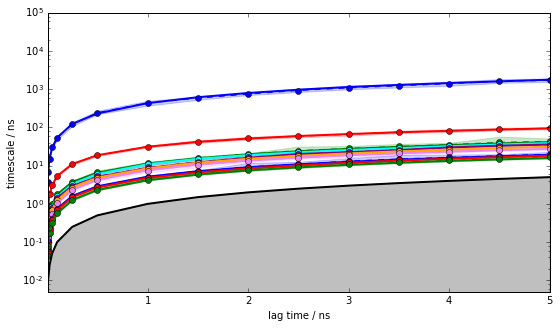

In [9]:
font = {'family' : 'serif',
        'weight' : '400',
        'size'   : 14}
figsize(9,5)
mplt.plot_implied_timescales(its, dt=0.005, units='ns', linewidth=2)
ylim(0,100000)

In [10]:
# WARNING: This takes ages (> 12h) to run and takes up a LOT of memory
# remove the errors='bayes' to make it more maneageable
lags = [5,50,100,200,400,600,800,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000]
its = msm.its(wt_dtrajs,lags=lags, nits=10, errors='bayes')

estimating BayesianMSM: 100% (17/17) [#############################] eta 00:00 \

(0.025000000000000001, 100000)

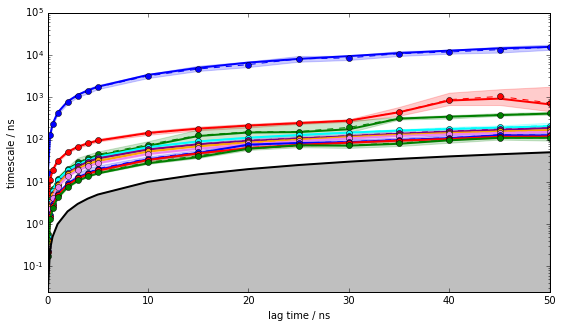

In [11]:
font = {'family' : 'serif',
        'weight' : '400',
        'size'   : 14}
figsize(9,5)
mplt.plot_implied_timescales(its, dt=0.005, units='ns', linewidth=2)
ylim(0,100000)

In [3]:
if os.path.isdir('CypA_MSM_output_files') == False:
    os.system('mkdir CypA_MSM_output_files')
f=open('CypA_MSM_output_files/its_50ns_witherror.pickle', 'w')
pickle.dump(its,f)
f.close()

Yauh


In [8]:
zfile = open('Intermediate_pickle_files/wt-d66a_cattraj_contourmap.pickle', 'r')
Z=pickle.load(zfile)
zfile.close()

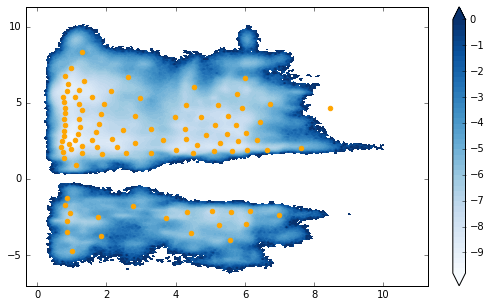

In [9]:
cc_x=combined_centers[:,0]
cc_y=combined_centers[:,1]
font = {'family' : 'serif',
        'weight' : '400',
        'size'   : 14}
figsize(9,5)
contourf(Z.T, 50, cmap=plt.cm.Blues, extent=[0.2039,10.7500,-6.1849,10.4978], extend='both')
colorbar()
scatter(cc_x, cc_y, color='orange', s=20)

## MSM (40 ns)

In [10]:
M = msm.bayesian_markov_model(wt_dtrajs,8000)

In [11]:
print '--- Bayesian MSM ---'
print 'fraction of states used = ', M.active_state_fraction
print 'fraction of counts used = ', M.active_count_fraction

--- Bayesian MSM ---
fraction of states used =  1.0
fraction of counts used =  1.0


In [12]:
M.get_model_params

<bound method MaximumLikelihoodMSM.get_model_params of MaximumLikelihoodMSM(connectivity='largest', count_mode='sliding',
           dt_traj='1 step', lag=8000, maxerr=1e-08, maxiter=1000000,
           reversible=True, score_k=10, score_method='VAMP2', sparse=False,
           statdist_constraint=None)>

In [89]:
stat_dist = M.stationary_distribution
f = open('CypA_MSM_output_files/CypA_bayes_MSM_40ns.stat_distribution.pickle', 'w')
pickle.dump(stat_dist,f)
f.close()

In [14]:
trans_matrix = M.transition_matrix
f = open('CypA_MSM_output_files/CypA_bayes_MSM_40ns.transition_matrix.pickle', 'w')
pickle.dump(trans_matrix, f)
f.close()

In [15]:
evl = M.eigenvectors_left()
evr = M.eigenvectors_right()

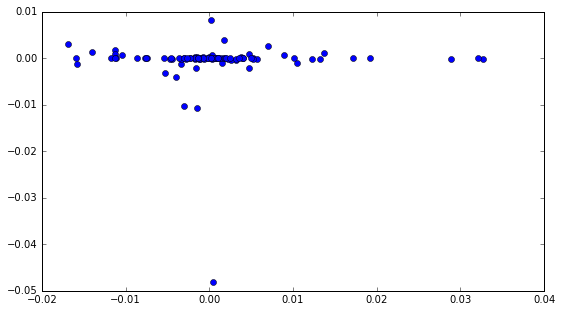

In [16]:
figsize(9,5)
plt.plot(evl[:,1], evl[:,2], marker ='o', linewidth=0)

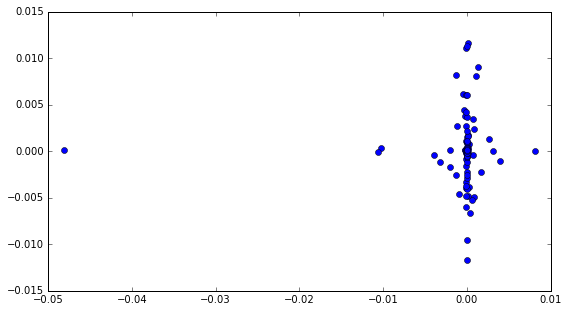

In [17]:
plt.plot(evl[:,2], evl[:,3], marker ='o', linewidth=0)

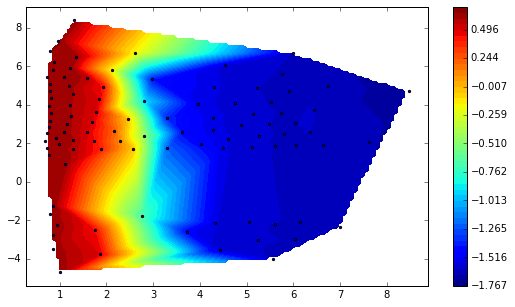

In [18]:
cc_x=combined_centers[:,0]
cc_y=combined_centers[:,1]
r2= M.eigenvectors_right()[:,1]
ax = mplt.scatter_contour(cc_x,cc_y,r2)

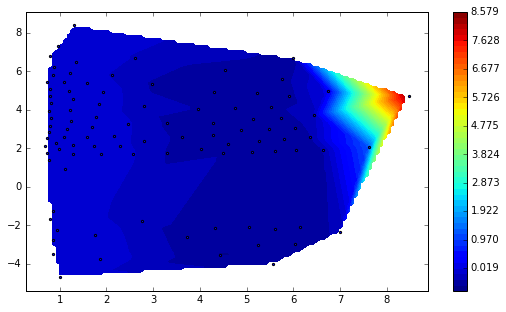

In [19]:
r3= M.eigenvectors_right()[:,2]
ax = mplt.scatter_contour(cc_x,cc_y,r3)

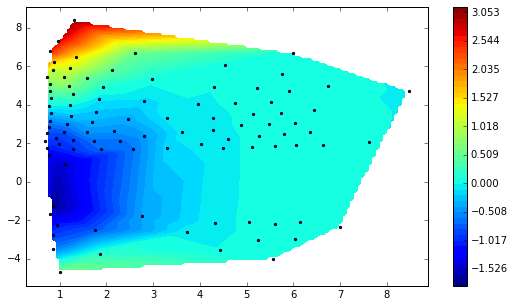

In [20]:
r4= M.eigenvectors_right()[:,3]
ax = mplt.scatter_contour(cc_x,cc_y,r4)

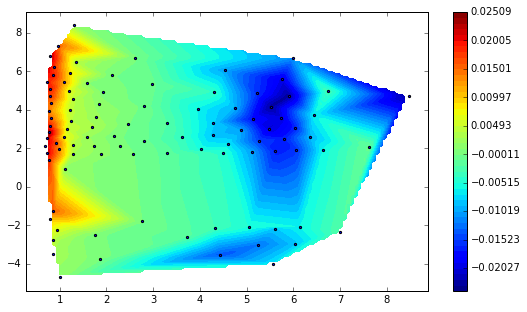

In [21]:
cc_x=combined_centers[:,0]
cc_y=combined_centers[:,1]
l2= M.eigenvectors_left()[1,:]
ax = mplt.scatter_contour(cc_x,cc_y,l2)

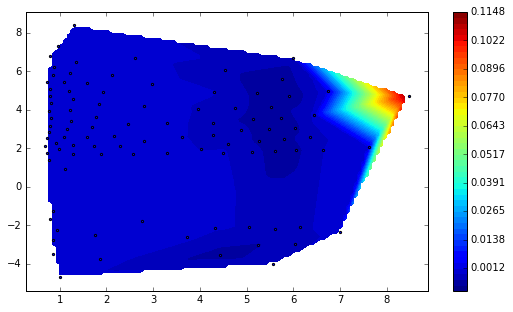

In [22]:
l3= M.eigenvectors_left()[2,:]
ax = mplt.scatter_contour(cc_x,cc_y,l3)

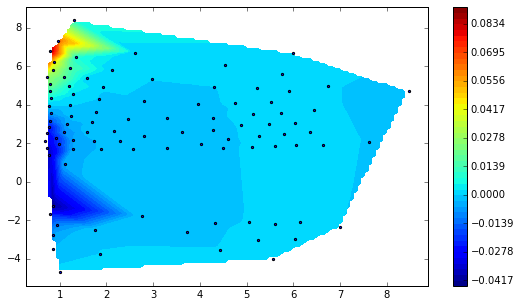

In [23]:
l4= M.eigenvectors_left()[3,:]
ax = mplt.scatter_contour(cc_x,cc_y,l4)

In [67]:
count_matrix = M.count_matrix_full
f= open('CypA_MSM_output_files/CypA.40ns_Bayes_MSM.count_matrix.pickle', 'w')
pickle.dump(count_matrix, f)
f.close()

100


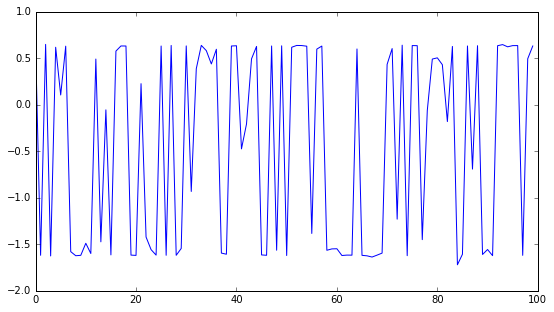

In [24]:
print len(M.eigenvectors_right())
plt.plot(M.eigenvectors_right()[:,1])

(-0.5, 10.5)

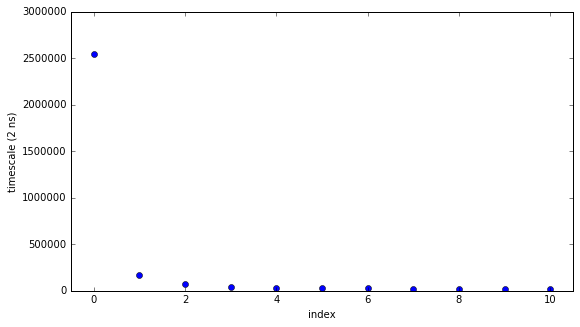

In [25]:
plot(M.timescales(), linewidth=0, marker='o')
xlabel('index'); ylabel('timescale (2 ns)'); xlim(-0.5,10.5)

(0, 5)

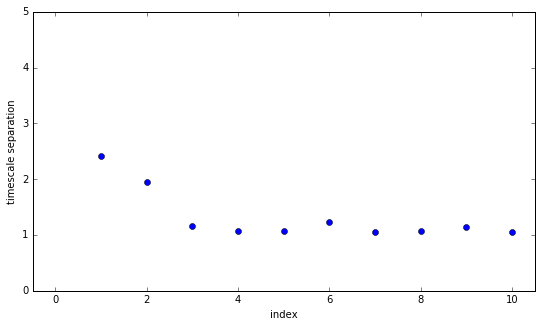

In [26]:
plot(M.timescales()[:-1]/M.timescales()[1:], linewidth=0, marker='o')
xlabel('index'); ylabel('timescale separation'); xlim(-0.5,10.5); ylim(0,5)

(0.6, 1.2)

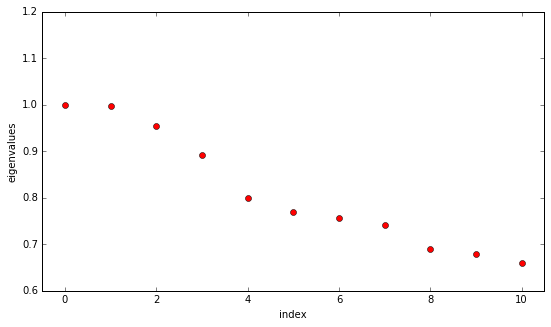

In [27]:
plot(M.eigenvalues(), linewidth=0, marker='o', color='red')
xlabel('index'); ylabel('eigenvalues'); xlim(-0.5,10.5); ylim(0.6,1.2)

In [28]:
centers=combined_centers

## 5 States Crisp Manual Assignment

In [13]:
man_magenta = []
man_orange = []
man_red = []
man_teal = []
#man_purple = []
man_blue = []
for i in range(len(combined_centers)):
    cc_x = combined_centers[i][0]
    cc_y = combined_centers[i][1]
    if cc_x > 4.0:
        if cc_y > 4.5:
            man_blue.append(i)
        else:
            man_magenta.append(i)
    elif cc_x >1.5 and cc_x <= 4.0:
        man_teal.append(i)
    elif cc_x <=1.5 and cc_y > 4.5:
        man_red.append(i)
    else:
        man_orange.append(i)

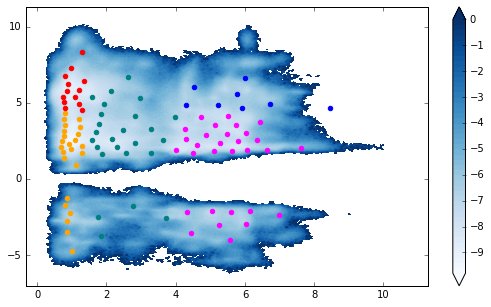

In [14]:
centers = combined_centers
font = {'family' : 'serif',
        'weight' : '400',
        'size'   : 14}
figsize(9,5)
contourf(Z.T, 50, cmap=plt.cm.Blues, extent=[0.2039,10.7500,-6.1849,10.4978], extend='both')
colorbar()
scatter(centers[man_blue,0], centers[man_blue,1], color='blue', s=20)
scatter(centers[man_teal,0], centers[man_teal,1], color='teal', s=20)
scatter(centers[man_magenta,0], centers[man_magenta,1], color='magenta', s=20)
scatter(centers[man_orange,0], centers[man_orange,1], color='orange', s=20)
scatter(centers[man_red,0], centers[man_red,1], color='red', s=20)
#scatter(centers[man_purple,0], centers[man_purple,1], color='purple', s=20)

### MFPT 

In [35]:
states = ['orange', 'magenta', 'blue', 'teal', 'red']
microstates = [man_orange, man_magenta, man_blue, man_teal, man_red]

In [36]:
for i in range(len(states)):
    np.savetxt('CypA_MSM_output_files/%s_macro.txt' % states[i], microstates[i])
    

In [38]:
mfptmatrix = {}
for ini in states:
    for fin in states:
        mfptmatrix[ini+'->'+fin] = []
print mfptmatrix

{'red->magenta': [], 'teal->red': [], 'blue->teal': [], 'red->teal': [], 'teal->magenta': [], 'blue->red': [], 'magenta->blue': [], 'orange->teal': [], 'magenta->orange': [], 'blue->orange': [], 'teal->teal': [], 'teal->orange': [], 'red->blue': [], 'magenta->red': [], 'red->orange': [], 'blue->blue': [], 'teal->blue': [], 'orange->blue': [], 'orange->magenta': [], 'red->red': [], 'orange->red': [], 'magenta->teal': [], 'orange->orange': [], 'blue->magenta': [], 'magenta->magenta': []}


In [39]:
for i in range(len(states)):
    A = microstates[i]
    for o in range(len(microstates)):
        transition = states[i]+'->'+states[o]
        B = microstates[o]
        passtime = 5*1E-12*M.mfpt(A,B)
        mfptmatrix[transition].append(passtime)
print mfptmatrix

{'red->magenta': [4.5352877724427863e-05], 'teal->red': [6.5420762815456563e-06], 'blue->teal': [1.9435527373153435e-06], 'red->teal': [3.6097399588861161e-06], 'teal->magenta': [3.063088505318727e-05], 'blue->red': [1.8891902711179464e-05], 'magenta->blue': [2.2028894242846432e-06], 'orange->teal': [3.541879596795189e-06], 'magenta->orange': [1.8024399077916992e-05], 'blue->orange': [1.8229673552313212e-05], 'teal->teal': [0.0], 'teal->orange': [5.910373715527227e-06], 'red->blue': [4.7926677156043933e-05], 'magenta->red': [1.868935386986082e-05], 'red->orange': [4.5901059513986422e-07], 'blue->blue': [0.0], 'teal->blue': [3.3149068496600248e-05], 'orange->blue': [4.7771561442810016e-05], 'orange->magenta': [4.5193126454663397e-05], 'red->red': [0.0], 'orange->red': [9.5846276512294381e-07], 'magenta->teal': [1.7433979921025196e-06], 'orange->orange': [0.0], 'blue->magenta': [6.2614417440446625e-07], 'magenta->magenta': [0.0]}


In [48]:
print man_magenta
print man_red
print man_orange
print man_teal
print man_blue

[3, 8, 9, 11, 13, 15, 20, 24, 26, 28, 37, 38, 45, 48, 50, 58, 59, 60, 62, 63, 65, 66, 67, 68, 69, 85, 89, 90, 91, 97]
[0, 2, 27, 52, 53, 56, 73, 75, 76, 88, 92, 93, 94]
[4, 6, 17, 18, 25, 30, 33, 34, 36, 39, 40, 44, 47, 49, 51, 54, 57, 64, 71, 83, 86, 95, 96, 99]
[5, 10, 12, 14, 16, 21, 22, 29, 31, 32, 35, 41, 42, 43, 55, 70, 72, 77, 78, 79, 80, 81, 82, 87, 98]
[1, 7, 19, 23, 46, 61, 74, 84]


In [118]:
f=open('CypA_MSM_output_files/cypa_bayesian_MSM_in_s.mfptmatrix.dat','w')
pickle.dump(mfptmatrix,f)
f.close()

### Macrostates population

In [38]:
crisp_pop_dict = {'orange':[],
              'magenta':[],
              'teal':[],
              'blue':[],
              'red':[]
              }
cumpop = 0
#blue
pop = 0
for state in man_blue:
    pop= pop + M.stationary_distribution[state]
crisp_pop_dict['blue'].append(pop)
#print pop
cumpop = cumpop + pop
#teal
pop = 0
for state in man_teal:
    pop= pop + M.stationary_distribution[state]
crisp_pop_dict['teal'].append(pop)
#print pop
cumpop = cumpop + pop
#red
pop = 0
for state in man_red:
    pop= pop + M.stationary_distribution[state]
crisp_pop_dict['red'].append(pop)
#print pop
cumpop = cumpop + pop
#magenta
pop = 0
for state in man_magenta:
    pop= pop + M.stationary_distribution[state]
crisp_pop_dict['magenta'].append(pop)
#print pop
cumpop = cumpop + pop
#orange
pop = 0
for state in man_orange:
    pop= pop + M.stationary_distribution[state]
crisp_pop_dict['orange'].append(pop)
#print pop
cumpop = cumpop + pop

print "Cummulative population: %f" % cumpop
print crisp_pop_dict

Cummulative population: 1.000000
{'orange': [0.42156623205009458], 'blue': [0.06785334239259469], 'magenta': [0.19860432799463268], 'red': [0.26338844975735237], 'teal': [0.048587647805325838]}


### MFPT within macrostates

In [84]:
orange_mfpts = []
for ini in man_orange:
    for final in man_orange:
        #A= [ini]
        #B = [final]
        #orange_mfpts.append(5*1E-6*M.mfpt(A,B))
        if ini != final:
            A= [ini]
            B = [final]
            orange_mfpts.append(5*1E-6*M.mfpt(A,B))

magenta_mfpts = []
for ini in man_magenta:
    for final in man_magenta:
        if ini != final:
            A= [ini]
            B = [final]
            magenta_mfpts.append(5*1E-6*M.mfpt(A,B))
            
red_mfpts = []
for ini in man_red:
    for final in man_red:
        if ini != final:
            A= [ini]
            B = [final]
            red_mfpts.append(5*1E-6*M.mfpt(A,B))

blue_mfpts = []
for ini in man_blue:
    for final in man_blue:
        if ini != final:
            A= [ini]
            B = [final]
            blue_mfpts.append(5*1E-6*M.mfpt(A,B))
            
teal_mfpts = []
for ini in man_teal:
    for final in man_teal:
        if ini != final:
            A= [ini]
            B = [final]
            teal_mfpts.append(5*1E-6*M.mfpt(A,B))

### REPRESENTATIVE STRUCTURES

In [22]:
myrootpath = '/home/jjuarez/Work/UEDIN/ISOTRAPSS/CONF_ANALYSIS/CYPA/'
myfile=open(myrootpath + 'MSM_DIR_RMSD/cypa_traj_cattraj.pickle')
trajfiles = pickle.load(myfile)
myfile.close()
topfile = myrootpath + 'AMD_PROD_RUNS/dry_grofiles/cypa.dry.gro'
top = topfile
topology = coor.featurizer(top)
inp = coor.source(trajfiles, topology)

Obtaining file info: 100% (1205/1205) [############################] eta 00:01 -

#### MICROSTATES REPRESENTATIVE STRUCTURES

In [ ]:
rootpath='/home/jjuarez/Work/UEDIN/ISOTRAPSS/CONF_ANALYSIS/CYPA/MSM_DIR_RMSD/COMBINED_WT-D66A_DIR_RMSD_100s/microMSM_repsnapshots_WT'

In [42]:
micro_samples = get_microstate_samples(wt_dtrajs,M.stationary_distribution,100)

Found 100 samples for state 17
Found 100 samples for state 86
Found 100 samples for state 99
Found 100 samples for state 54
Found 100 samples for state 52
Found 100 samples for state 76
Found 100 samples for state 47
Found 100 samples for state 53
Found 100 samples for state 18
Found 100 samples for state 30
Found 100 samples for state 27
Found 100 samples for state 57
Found 100 samples for state 49
Found 100 samples for state 44
Found 100 samples for state 26
Found 100 samples for state 97
Found 100 samples for state 83
Found 100 samples for state 91
Found 100 samples for state 40
Found 100 samples for state 73
Found 100 samples for state 92
Found 100 samples for state 85
Found 100 samples for state 63
Found 100 samples for state 68
Found 100 samples for state 15
Found 100 samples for state 89
Found 100 samples for state 28
Found 100 samples for state 59
Found 100 samples for state 93
Found 100 samples for state 58
Found 100 samples for state 60
Found 100 samples for state 51
Found 10

In [55]:
filenames = []
rootpath =  'microMSM_repsnapshots_WT/'
for state in range(len(M.stationary_distribution)):
    filename = '%s/microstate_%s.xtc' % (rootpath,state)
    filenames.append(filename)

In [57]:
coor.save_trajs(inp, micro_samples, outfiles=filenames, inmemory=True)

11-07-18 14:34:05 pyemma.coordinates.api INFO     Created file microMSM_repsnapshots_WT//microstate_0.xtc
11-07-18 14:34:05 pyemma.coordinates.api INFO     Created file microMSM_repsnapshots_WT//microstate_1.xtc
11-07-18 14:34:05 pyemma.coordinates.api INFO     Created file microMSM_repsnapshots_WT//microstate_2.xtc
11-07-18 14:34:07 pyemma.coordinates.api INFO     Created file microMSM_repsnapshots_WT//microstate_3.xtc
11-07-18 14:34:07 pyemma.coordinates.api INFO     Created file microMSM_repsnapshots_WT//microstate_4.xtc
11-07-18 14:34:07 pyemma.coordinates.api INFO     Created file microMSM_repsnapshots_WT//microstate_5.xtc
11-07-18 14:34:07 pyemma.coordinates.api INFO     Created file microMSM_repsnapshots_WT//microstate_6.xtc
11-07-18 14:34:07 pyemma.coordinates.api INFO     Created file microMSM_repsnapshots_WT//microstate_7.xtc
11-07-18 14:34:07 pyemma.coordinates.api INFO     Created file microMSM_repsnapshots_WT//microstate_8.xtc
11-07-18 14:34:07 pyemma.coordinates.api INFO 

['microMSM_repsnapshots_WT//microstate_0.xtc',
 'microMSM_repsnapshots_WT//microstate_1.xtc',
 'microMSM_repsnapshots_WT//microstate_2.xtc',
 'microMSM_repsnapshots_WT//microstate_3.xtc',
 'microMSM_repsnapshots_WT//microstate_4.xtc',
 'microMSM_repsnapshots_WT//microstate_5.xtc',
 'microMSM_repsnapshots_WT//microstate_6.xtc',
 'microMSM_repsnapshots_WT//microstate_7.xtc',
 'microMSM_repsnapshots_WT//microstate_8.xtc',
 'microMSM_repsnapshots_WT//microstate_9.xtc',
 'microMSM_repsnapshots_WT//microstate_10.xtc',
 'microMSM_repsnapshots_WT//microstate_11.xtc',
 'microMSM_repsnapshots_WT//microstate_12.xtc',
 'microMSM_repsnapshots_WT//microstate_13.xtc',
 'microMSM_repsnapshots_WT//microstate_14.xtc',
 'microMSM_repsnapshots_WT//microstate_15.xtc',
 'microMSM_repsnapshots_WT//microstate_16.xtc',
 'microMSM_repsnapshots_WT//microstate_17.xtc',
 'microMSM_repsnapshots_WT//microstate_18.xtc',
 'microMSM_repsnapshots_WT//microstate_19.xtc',
 'microMSM_repsnapshots_WT//microstate_20.xtc',
 '

#### MACROSTATES REPRESENTATIVE STRUCTURES

In [40]:
states = ['orange', 'magenta', 'blue', 'teal', 'red']
microstates = [man_orange, man_magenta, man_blue, man_teal, man_red]
print states

['orange', 'magenta', 'blue', 'teal', 'red']


In [41]:
crisp_samples = sample_from_crisp_assigment(wt_dtrajs,microstates,1000)

In [43]:
rootpath='/home/jjuarez/Work/UEDIN/ISOTRAPSS/CONF_ANALYSIS/CYPA/MSM_DIR_RMSD/COMBINED_WT-D66A_DIR_RMSD_100s/CYPA_CRISP_REP_STRUCTURES/'
clust1=rootpath + 'crisp_orange_1000-samples.xtc'
clust2=rootpath + 'crisp_magenta_1000-samples.xtc'
clust3=rootpath + 'crisp_blue_1000-samples.xtc'
clust4=rootpath + 'crisp_teal_1000-samples.xtc'
clust5=rootpath + 'crisp_red_1000-samples.xtc'

In [45]:
coor.save_trajs(inp, crisp_samples, outfiles=[clust1,clust2,clust3,clust4,clust5], inmemory=True)

10-04-17 10:39:03 pyemma.coordinates.api INFO     Created file /home/jjuarez/Work/UEDIN/ISOTRAPSS/CONF_ANALYSIS/CYPA/MSM_DIR_RMSD/COMBINED_CVSPACE_DIR_RMSD_100s/CYPA_CRISP_REP_STRUCTURES/crisp_orange_1000-samples.xtc
10-04-17 10:39:03 pyemma.coordinates.api INFO     Created file /home/jjuarez/Work/UEDIN/ISOTRAPSS/CONF_ANALYSIS/CYPA/MSM_DIR_RMSD/COMBINED_CVSPACE_DIR_RMSD_100s/CYPA_CRISP_REP_STRUCTURES/crisp_magenta_1000-samples.xtc
10-04-17 10:39:03 pyemma.coordinates.api INFO     Created file /home/jjuarez/Work/UEDIN/ISOTRAPSS/CONF_ANALYSIS/CYPA/MSM_DIR_RMSD/COMBINED_CVSPACE_DIR_RMSD_100s/CYPA_CRISP_REP_STRUCTURES/crisp_blue_1000-samples.xtc
10-04-17 10:39:04 pyemma.coordinates.api INFO     Created file /home/jjuarez/Work/UEDIN/ISOTRAPSS/CONF_ANALYSIS/CYPA/MSM_DIR_RMSD/COMBINED_CVSPACE_DIR_RMSD_100s/CYPA_CRISP_REP_STRUCTURES/crisp_teal_1000-samples.xtc
10-04-17 10:39:04 pyemma.coordinates.api INFO     Created file /home/jjuarez/Work/UEDIN/ISOTRAPSS/CONF_ANALYSIS/CYPA/MSM_DIR_RMSD/COMBI

['/home/jjuarez/Work/UEDIN/ISOTRAPSS/CONF_ANALYSIS/CYPA/MSM_DIR_RMSD/COMBINED_CVSPACE_DIR_RMSD_100s/CYPA_CRISP_REP_STRUCTURES/crisp_orange_1000-samples.xtc',
 '/home/jjuarez/Work/UEDIN/ISOTRAPSS/CONF_ANALYSIS/CYPA/MSM_DIR_RMSD/COMBINED_CVSPACE_DIR_RMSD_100s/CYPA_CRISP_REP_STRUCTURES/crisp_magenta_1000-samples.xtc',
 '/home/jjuarez/Work/UEDIN/ISOTRAPSS/CONF_ANALYSIS/CYPA/MSM_DIR_RMSD/COMBINED_CVSPACE_DIR_RMSD_100s/CYPA_CRISP_REP_STRUCTURES/crisp_blue_1000-samples.xtc',
 '/home/jjuarez/Work/UEDIN/ISOTRAPSS/CONF_ANALYSIS/CYPA/MSM_DIR_RMSD/COMBINED_CVSPACE_DIR_RMSD_100s/CYPA_CRISP_REP_STRUCTURES/crisp_teal_1000-samples.xtc',
 '/home/jjuarez/Work/UEDIN/ISOTRAPSS/CONF_ANALYSIS/CYPA/MSM_DIR_RMSD/COMBINED_CVSPACE_DIR_RMSD_100s/CYPA_CRISP_REP_STRUCTURES/crisp_red_1000-samples.xtc']